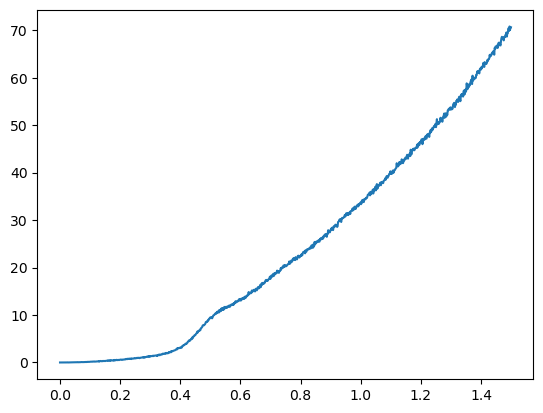

In [2]:
from functools import partial

import matplotlib.pyplot as plt

from sandbox import coordinates, distribution, iterators

test = coordinates.System(
    trajectory="data/test.xtc", topology="data/test.gro", xyz_filter="(x > 1.0)"
)

rdf = partial(distribution.radial_distribution)

hist, bins = iterators.time_average(rdf, test, com=True, stride=10)

plt.plot(bins, hist)
plt.show()